<a href="https://colab.research.google.com/github/Nehalokesh/Hotel-booking-analysis/blob/main/Hotel_Booking_Analysis_Solution_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <b> Have you ever wondered when the best time of year to book a hotel room is? Or the optimal length of stay in order to get the best daily rate? What if you wanted to predict whether or not a hotel was likely to receive a disproportionately high number of special requests? This hotel booking dataset can help you explore those questions!

## <b>This data set contains booking information for a city hotel and a resort hotel, and includes information such as when the booking was made, length of stay, the number of adults, children, and/or babies, and the number of available parking spaces, among other things. All personally identifying information has been removed from the data. </b>

## <b> Explore and analyze the data to discover important factors that govern the bookings. </b>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
hotel = pd.read_csv('/content/drive/MyDrive/Almabetter/Module 1/Capstone Project/Hotel Bookings.csv')

# briefly view the data
hotel.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [ ]:
# get more information such as data type, number of columns and entries
hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

It illustrates that some columns such as company contains null values.

## **Data Cleaning**

In [ ]:
# a function to create a dataframe to illustrate a summary of missing values
def missing_describe(df):
    total_missing = df.isnull().sum().sort_values(ascending=False)

    total_missing = total_missing[total_missing.values !=0]

    per = np.round(total_missing.values*100.00/len(df), 2)

    dataframe = pd.DataFrame(total_missing, columns=['number_of_missing_values'])

    return (dataframe.assign(percentage=per))

In [ ]:
missing_describe(hotel)

,number_of_missing_values,percentage
company,112593,94.31
agent,16340,13.69
country,488,0.41
children,4,0.00


In [ ]:
'''
handle missing values:
- country: it is replaced with unknown
- children: it is repalced with 0 
- drop company and agent since we couldn't know the name because of the anonymity reasons
'''
nan_replacement = {
    "children": 0,
    "country": "Unknown",
}
hotel_filled = hotel.fillna(nan_replacement)
hotel_filled.drop(['company', 'agent'], axis=1, inplace=True)

# according to the research paper: "meal" contains value "Undefined", which is equal to SC (no meal package)
hotel_filled['meal'].replace("Undefined", "SC", inplace=True)

# drop columns that won't be using 
hotel_filled.drop(['arrival_date_week_number', 'reservation_status_date'], axis=1, inplace=True)

In [ ]:
# create two columns which are total guests and total stays
hotel_filled['total_guests'] = hotel_filled['adults'] + hotel_filled['children'] + hotel_filled['babies']
hotel_filled['total_stays'] = hotel_filled['stays_in_weekend_nights'] + hotel_filled['stays_in_week_nights']

In [ ]:
# drop 180 entries that include 0 Total Guests
hotel_filled = hotel_filled[hotel_filled['total_guests'] != 0]

In [ ]:
'''
setting the "children" column as a boolean indicator:
- travel with at least one children as 1
- travel with no children as 0
'''
hotel_filled['children'] = (hotel_filled['children'] + hotel_filled['babies'] > 0).astype(int)

# drop the redundant column - 'babies'
hotel_filled.drop('babies', axis=1, inplace=True)

In [ ]:
# convert month name into month number e.g. January = 1
month_repalcement = {
    "January": 1,
    "February": 2,
    "March": 3,
    "April": 4,
    "May": 5,
    "June": 6,
    "July": 7,
    "August": 8,
    "September": 9,
    "October": 10,
    "November": 11,
    "December": 12
}

hotel_filled['arrival_date_month'] = hotel_filled['arrival_date_month'].map(month_repalcement)

# create the arrival date column 
hotel_filled['arrival_date'] = hotel_filled['arrival_date_year'].map(str) + '-' + hotel_filled['arrival_date_month'].map(str) + '-' + hotel_filled['arrival_date_day_of_month'].map(str)

# converting data type (object to datetime)
hotel_filled['arrival_date'] = pd.to_datetime(hotel_filled['arrival_date'])

# change format into yyyy-mm-dd
hotel_filled["arrival_date"].dt.strftime("%y/%m/%d")

# drop column 
hotel_filled.drop('arrival_date_day_of_month', axis=1, inplace=True)

In [ ]:
# create a dataframe which only includes people who have arrived
hotel_arrival = hotel_filled[hotel_filled['is_canceled'] == 0]

# create a dataframe which only inlcudes people who visited city hotel
city_hotel = hotel_filled[hotel_filled['hotel'] == 'City Hotel']

# create a dataframe which only inlcudes people who visited resort hotel
resort_hotel = hotel_filled[hotel_filled['hotel'] == 'Resort Hotel']

In [ ]:
# double check the missing values
hotel_arrival.isna().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
reservation_status                0
total_guests                      0
total_stays                 

## **Data Exploration**

In [ ]:
# desciptive summary of the data
hotel_arrival.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,total_guests,total_stays
count,75011.0,75011.000000,75011.000000,75011.000000,75011.000000,75011.000000,75011.000000,75011.000000,75011.000000,75011.000000,75011.000000,75011.000000,75011.000000,75011.000000,75011.000000,75011.000000,75011.000000,75011.000000
mean,0.0,80.082028,2016.147445,6.525536,0.928064,2.461999,1.833518,0.080961,0.042727,0.015758,0.203064,0.289784,1.587687,100.169212,0.099412,0.714455,1.946475,3.390063
std,0.0,91.137797,0.703101,3.152481,0.987820,1.907424,0.504148,0.272778,0.202242,0.272486,1.812020,0.717243,14.781224,49.070644,0.303332,0.834026,0.664807,2.551614
min,0.0,0.000000,2015.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000,1.000000,0.000000
25%,0.0,9.000000,2016.000000,4.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67.760000,0.000000,0.000000,2.000000,2.000000
50%,0.0,45.000000,2016.000000,7.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,92.700000,0.000000,1.000000,2.000000,3.000000
75%,0.0,124.000000,2017.000000,9.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,125.000000,0.000000,1.000000,2.000000,4.000000
max,0.0,737.000000,2017.000000,12.000000,19.000000,50.000000,4.000000,1.000000,1.000000,13.000000,72.000000,18.000000,379.000000,510.000000,8.000000,5.000000,12.000000,69.000000


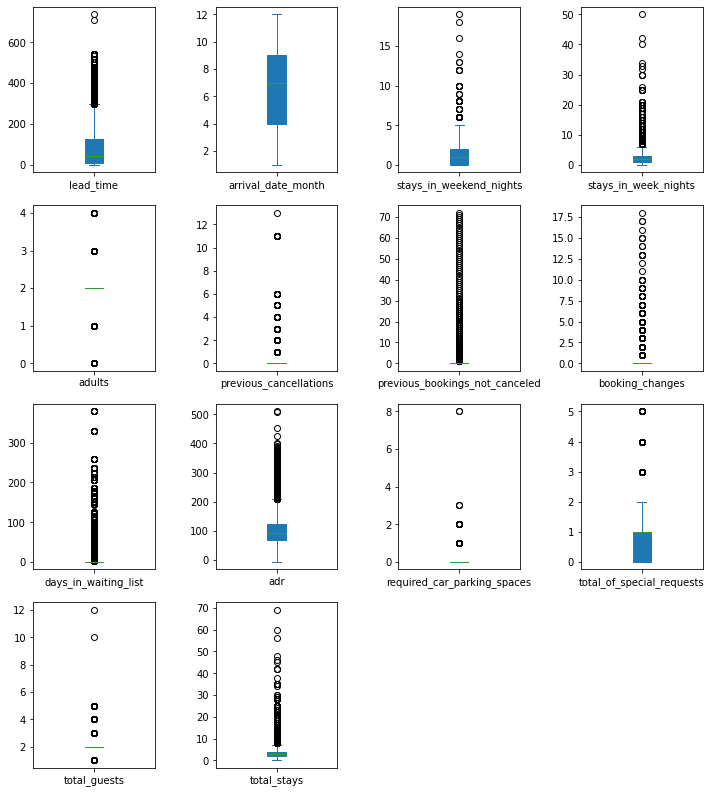

In [ ]:
# select columns to plot
df_to_plot = hotel_arrival.drop(columns=['is_canceled', 'arrival_date_year', 'children', 'is_repeated_guest']).select_dtypes(include=np.number)

# subplots 
df_to_plot.plot(subplots=True,
                layout=(4,4),
                kind='box',
                figsize=(12,14),
                patch_artist=True)
plt.subplots_adjust(wspace=0.5);

The boxplots demonstrate that there are few outliers in each column

## **Where do they come from? (TOP 10 Countries)**

     number_of_guest  percentage country
PRT            20977       27.97     PRT
GBR             9668       12.89     GBR
FRA             8468       11.29     FRA
ESP             6383        8.51     ESP
DEU             6067        8.09     DEU
IRL             2542        3.39     IRL
ITA             2428        3.24     ITA
BEL             1868        2.49     BEL
NLD             1716        2.29     NLD
USA             1592        2.12     USA


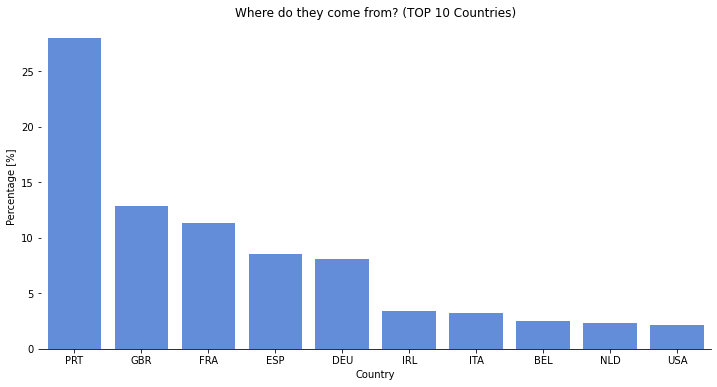

In [ ]:
# get the total number of hotel guests
total_guests = hotel_arrival['country'].value_counts().sum()

# a df for counting the number of guests based on country
country = pd.DataFrame(hotel_arrival['country'].value_counts().head(10))

# rename a column
country.rename(columns={"country": "number_of_guest"}, inplace=True)

# add the proportion column
country['percentage'] = round(country['number_of_guest'] / total_guests * 100, 2)

# add the country column
country["country"] = country.index

print(country)

# bar chart: where most tourists come from (top 10)
plt.figure(figsize=(12,6))
sns.barplot(
    data=country,
    x='country',y='percentage',
    color='#5086EC'
)
plt.ylabel("Percentage [%]")
plt.xlabel('Country')
plt.title('Where do they come from? (TOP 10 Countries)')
sns.despine(left=True)

Observations:

1.Most tourists come from Portugal (28.03%), followed by The UK(12.9%) and France (11.3%)

2.Most tourists come from Europe since the top 5 countries are in Europe

## **Market Segment**

In [ ]:
# a df for counting the number of guests by segment and hotel
market_segment = hotel_arrival.groupby(['hotel', 'market_segment'], as_index=False).size()

# rename a column
market_segment.rename(columns={"size": "number_of_guest"}, inplace=True)

# get the percentage
market_segment['percentage'] = round(market_segment['number_of_guest'] / total_guests * 100, 2)

market_segment

,hotel,market_segment,number_of_guest,percentage
0,City Hotel,Aviation,183,0.24
1,City Hotel,Complementary,471,0.63
2,City Hotel,Corporate,2337,3.12
3,City Hotel,Direct,5016,6.69
4,City Hotel,Groups,4339,5.78
5,City Hotel,Offline TA/TO,9546,12.73
6,City Hotel,Online TA,24192,32.25
7,Resort Hotel,Complementary,168,0.22
8,Resort Hotel,Corporate,1954,2.60
9,Resort Hotel,Direct,5632,7.51


Text(0.5, 0, 'market Segment')

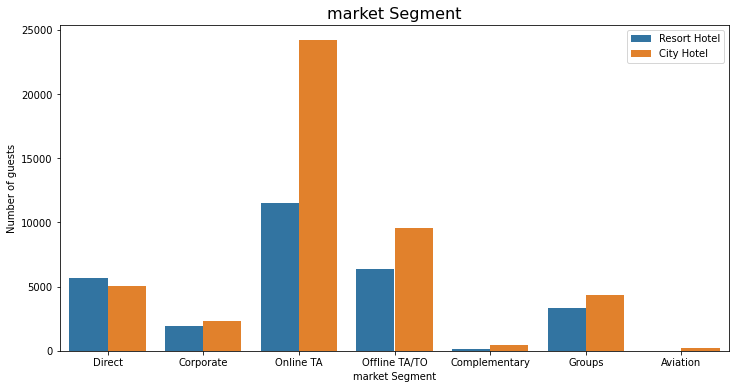

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(
    data=hotel_arrival,
    x='market_segment', hue='hotel'
)
plt.title('market Segment', fontsize = 16)
plt.legend(loc='upper right')
plt.ylabel('Number of guests')
plt.xlabel('market Segment')

Observations:

1. The major market segment for both hotels is Online Travel Agency (47.56%), followed by Offline Travel Agency or Travel Operator (21.17%)

2. City Hotel has a higher number of guests in all segments except for the direct segment

# **Travel with children vs Travel with no children**


Text(0.5, 1.0, 'Travel with children vs no children')

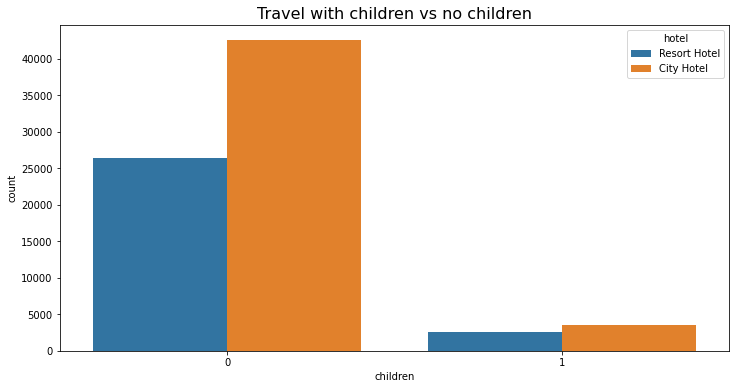

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(
    data=hotel_arrival,
    x='children', hue='hotel'
)
plt.title('Travel with children vs no children', fontsize = 16)

In [ ]:
# a df for counting the number of guests by hotel and children
family_trip = hotel_arrival.groupby(['hotel', 'children'], as_index=False).size()

# rename a column
family_trip.rename(columns={"size": "number_of_guest"}, inplace=True)

# get the percentage
family_trip['percentage'] = round(family_trip['number_of_guest'] / total_guests * 100, 2)

family_trip

,hotel,children,number_of_guest,percentage
0,City Hotel,0,42543,56.72
1,City Hotel,1,3541,4.72
2,Resort Hotel,0,26395,35.19
3,Resort Hotel,1,2532,3.38


Observations:

1. It illustrated that 91.92% of tourists travel with no children

2. less than 10% of tourists travel with children


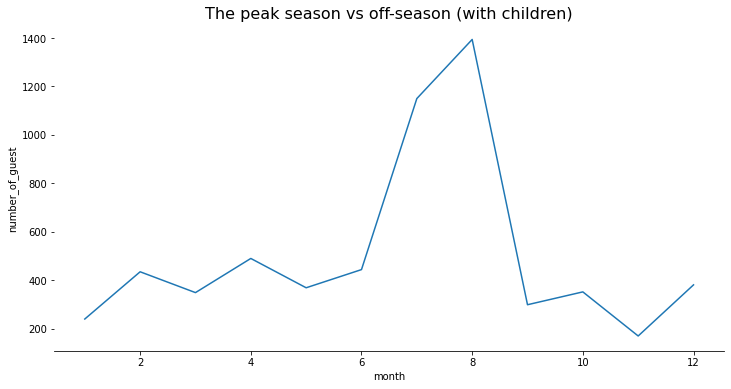

In [ ]:
children_month = hotel_arrival[hotel_arrival['children'] == 1].groupby(['arrival_date_month'], as_index=False).size()

children_month.rename(columns={"arrival_date_month": "month", "size": "number_of_guest"}, inplace=True)

plt.figure(figsize=(12,6))
sns.lineplot(
    data=children_month,
    x='month', y='number_of_guest'
)
plt.title('The peak season vs off-season (with children)', fontsize = 16)
sns.despine(left=True)

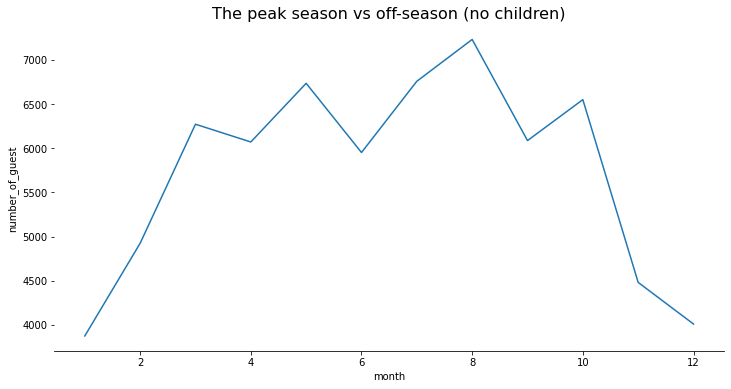

In [ ]:
no_children_month = hotel_arrival[hotel_arrival['children'] == 0].groupby(['arrival_date_month'], as_index=False).size()

no_children_month.rename(columns={"arrival_date_month": "month", "size": "number_of_guest"}, inplace=True)

plt.figure(figsize=(12,6))
sns.lineplot(
    data=no_children_month,
    x='month', y='number_of_guest'
)
plt.title('The peak season vs off-season (no children)', fontsize = 16)
sns.despine(left=True)

Observations:

1. Tourists who travel with no children are active between Feb and Nov

2. Family visitors tend to travel in the school holiday season (Jun-Sep). The seasonality is more pronounced than non-family visitors

Text(0.5, 1.0, 'repeated custoemrs?')

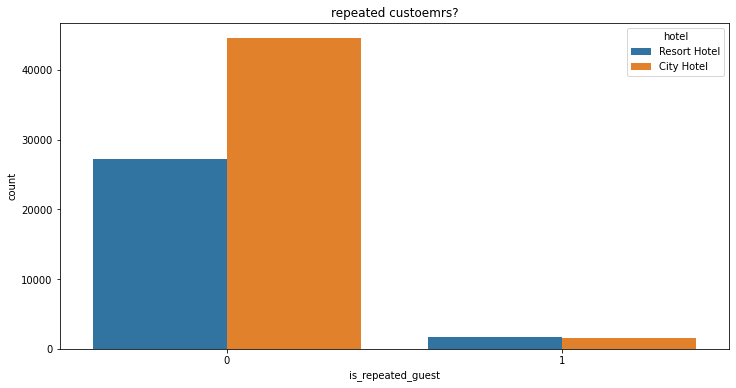

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(
    data=hotel_arrival,
    x='is_repeated_guest', hue='hotel'
)
plt.title('repeated custoemrs?')

In [ ]:
# a df for counting the number of guests by hotel and children
repeated_guest = hotel_arrival.groupby(['hotel', 'is_repeated_guest'], as_index=False).size()

# rename a column
repeated_guest.rename(columns={"size": "number_of_guest"}, inplace=True)

# get the percentage
repeated_guest['percentage'] = round(repeated_guest['number_of_guest'] / total_guests * 100, 2)

repeated_guest

,hotel,is_repeated_guest,number_of_guest,percentage
0,City Hotel,0,44546,59.39
1,City Hotel,1,1538,2.05
2,Resort Hotel,0,27260,36.34
3,Resort Hotel,1,1667,2.22


Observations:

1. less than 5% of visitors are repeated customer

2. City Hotel's first customers are 23% higher than Resort Hotel

3. Resort Hotel's repeated customers are slightly higher (0.17%)

In [ ]:
# a df for counting the number of guests by hotel and required parking spaces
car_park = hotel_arrival.groupby(['hotel', 'required_car_parking_spaces'], as_index=False).size()

# rename a column
car_park.rename(columns={"size": "number_of_guest"}, inplace=True)

# get the total number of guests by hotel
c = car_park[car_park['hotel'] == 'City Hotel']['number_of_guest'].sum()
r = car_park[car_park['hotel'] == 'Resort Hotel']['number_of_guest'].sum()

# add a percentage column
car_park.loc[car_park['hotel'] == 'City Hotel', 'percentage'] = round(car_park['number_of_guest'] / c,4)
car_park.loc[car_park['hotel'] == 'Resort Hotel', 'percentage'] = round(car_park['number_of_guest'] / r,4)

car_park

,hotel,required_car_parking_spaces,number_of_guest,percentage
0,City Hotel,0,44164,0.9583
1,City Hotel,1,1915,0.0416
2,City Hotel,2,3,0.0001
3,City Hotel,3,2,0.0000
4,Resort Hotel,0,23438,0.8102
5,Resort Hotel,1,5461,0.1888
6,Resort Hotel,2,25,0.0009
7,Resort Hotel,3,1,0.0000
8,Resort Hotel,8,2,0.0001


Text(0.5, 1.0, 'Required car parking spaces by hotel')

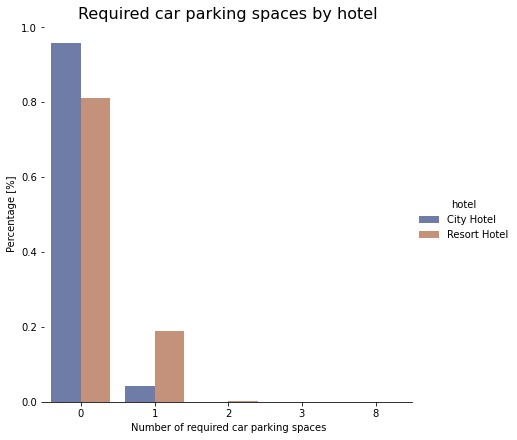

In [ ]:
sns.catplot(
    data=car_park, kind="bar",
    x="required_car_parking_spaces", y="percentage", hue="hotel",
    ci="sd", palette="dark", alpha=.6, height=6
)
sns.despine(left=True)
plt.ylabel("Percentage [%]")
plt.xlabel("Number of required car parking spaces")
plt.title("Required car parking spaces by hotel", fontsize = 16)

Observations:

1. 90% of visitors do not need car parking spaces.

2. nearly 19% of visitors from Resort Hotel require at least one car parking space.

3. only 4% of visitors from City Hotel require at least one car parking space

In [ ]:
# a df for counting the number of guests by hotel and meal
meal = hotel_arrival.groupby(['hotel', 'meal'], as_index=False).size()

# find the total number of order by hotels
c = meal[meal['hotel'] == 'City Hotel']['size'].sum()
r = meal[meal['hotel'] == 'Resort Hotel']['size'].sum()

# rename a column
meal.rename(columns={"size": "number_of_guest"}, inplace=True)

# add a percentage column 
meal.loc[meal['hotel'] == 'City Hotel', 'percentage'] = round(meal['number_of_guest'] / c,4)
meal.loc[meal['hotel'] == 'Resort Hotel', 'percentage'] = round(meal['number_of_guest'] / r,4)

Text(0.5, 1.0, 'How many visitors have bought a meal package?')

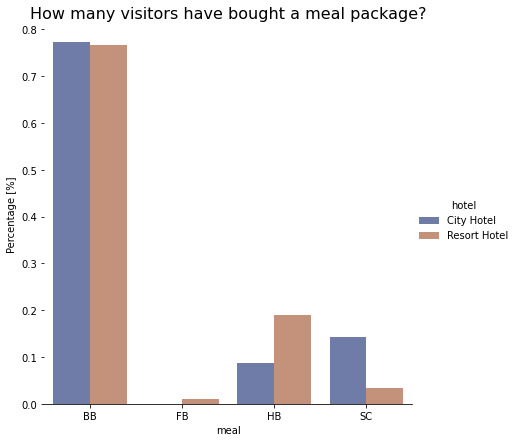

In [ ]:
sns.catplot(
    data=meal, kind="bar",
    x="meal", y="percentage", hue="hotel",
    ci="sd", palette="dark", alpha=.6, height=6
)
sns.despine(left=True)
plt.ylabel("Percentage [%]")
plt.title("How many visitors have bought a meal package?", fontsize = 16)

Obseravtion:

1. Nearly 80% of visitors from both hotels brought a breakfast package

2. Resort hotel received more Half Board orders than City hotel

3. Full board is the least option

# **Number of guests by booking channels(July 2015 to August 2017)**

In [ ]:
# extract data 
direct_booking = hotel_arrival[hotel_arrival['distribution_channel'] == 'Direct'][['arrival_date', 'total_guests']]
agency_booking = hotel_arrival[hotel_arrival['distribution_channel'] == 'TA/TO'][['arrival_date', 'total_guests']]
corporate_booking = hotel_arrival[hotel_arrival['distribution_channel'] == 'Corporate'][['arrival_date', 'total_guests']]
GDS_booking = hotel_arrival[hotel_arrival['distribution_channel'] == 'GDS'][['arrival_date', 'total_guests']]

# set arrival date as the index
direct_booking.set_index('arrival_date', inplace=True)
agency_booking.set_index('arrival_date', inplace=True)
corporate_booking.set_index('arrival_date', inplace=True)
GDS_booking.set_index('arrival_date',inplace=True)

# sum the number by month
direct_booking = direct_booking.resample('m').sum()
corporate_booking = corporate_booking.resample('m').sum()
GDS_booking = GDS_booking.resample('m').sum()
agency_booking = agency_booking.resample('m').sum()

# rename
direct_booking.rename(columns={'total_guests':'direct'}, inplace=True)
corporate_booking.rename(columns={'total_guests':'corporate'}, inplace=True)
GDS_booking.rename(columns={'total_guests':'GDS'}, inplace=True)
agency_booking.rename(columns={'total_guests':'agency'}, inplace=True)

# concat each df 
booking = pd.concat([direct_booking, corporate_booking['corporate'], GDS_booking['GDS'], agency_booking['agency']], axis=1)

# fill nan values with zero
booking.fillna(0)

,direct,corporate,GDS,agency
arrival_date,,,,
2015-07-31,609.0,23.0,0.0,2538.0
2015-08-31,1161.0,116.0,0.0,3518.0
2015-09-30,714.0,198.0,1.0,4581.0
2015-10-31,798.0,492.0,0.0,4481.0
2015-11-30,425.0,470.0,0.0,2130.0
2015-12-31,833.0,201.0,0.0,2652.0
2016-01-31,651.0,238.0,0.0,2013.0
2016-02-29,990.0,241.0,4.0,3459.0
2016-03-31,1101.0,272.0,6.0,4971.0


Text(0.5, 1.0, 'Number of guests by booking channels (2015-07-31 to 2017-08-31')

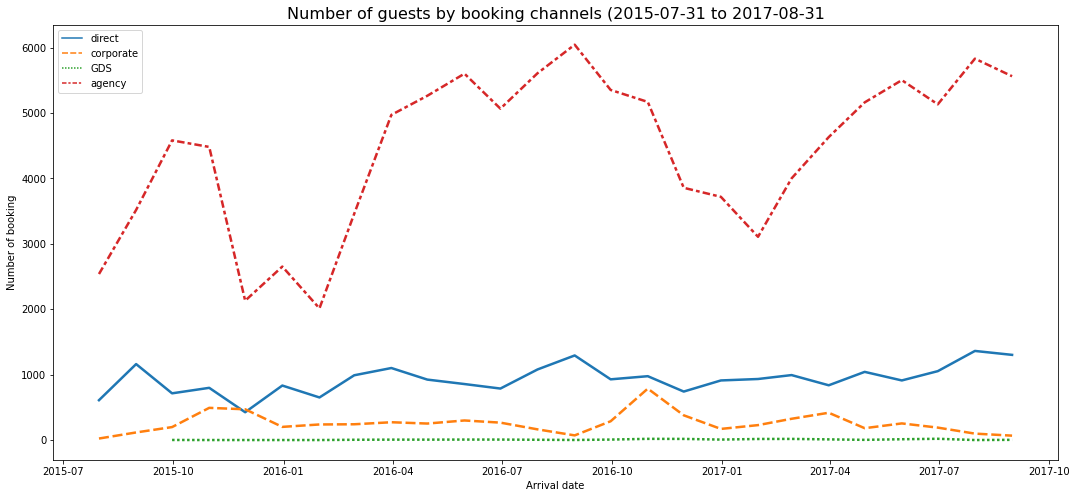

In [ ]:
plt.figure(figsize=(18,8))
sns.lineplot(
    data=booking,
    palette="tab10", linewidth=2.5
)
plt.ylabel('Number of booking')
plt.xlabel('Arrival date')
plt.title('Number of guests by booking channels (2015-07-31 to 2017-08-31', fontsize = 16)

Observations:

1. It illustrates that visitors tend to make their booking via travel agency (online or offline)

2. The trajectory of direct booking is relatively flat throughout 3 years, the number of bookings is between 800 and 1200.

3. The number of GDS and corporate bookings are generally below 500.

# **Number of Guest in July 2015 - Aug 2017**

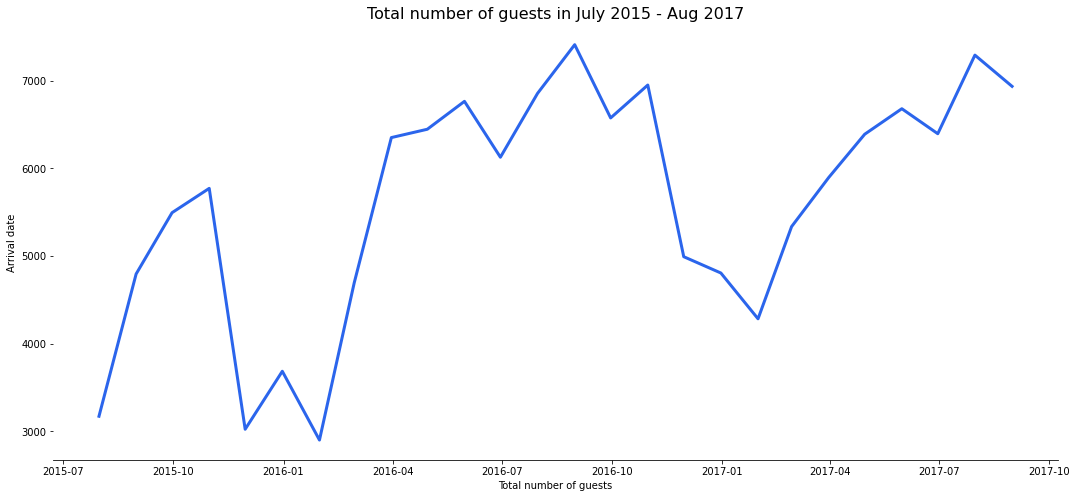

In [ ]:
# extract data 
total_guests_date = hotel_arrival[['arrival_date', 'total_guests']]

total_guests_date.set_index('arrival_date', inplace=True)

total_guests_date = total_guests_date.resample('m').sum()

plt.figure(figsize=(18,8))
sns.lineplot(
    data=total_guests_date,
    x='arrival_date', y='total_guests',
    lw=3, color='#2B65EC'
)
plt.xlabel('Total number of guests')
plt.ylabel('Arrival date')
plt.title('Total number of guests in July 2015 - Aug 2017', fontsize = 16)
sns.despine(left=True)

It illustrates that the peak season is July to September, whereas the off-season is December to February

## **Predict cancellations**

In [ ]:
corr = hotel_filled.drop(columns=['arrival_date_year', 'arrival_date_month']).select_dtypes(include=np.number)
cancel_corr = corr.corr()["is_canceled"]
cancel_corr.abs().sort_values(ascending=False)[1:]

lead_time                         0.292876
total_of_special_requests         0.234877
required_car_parking_spaces       0.195701
booking_changes                   0.144832
previous_cancellations            0.110139
is_repeated_guest                 0.083745
adults                            0.058182
previous_bookings_not_canceled    0.057365
days_in_waiting_list              0.054301
adr                               0.046492
total_guests                      0.044826
stays_in_week_nights              0.025542
total_stays                       0.018554
children                          0.012995
stays_in_weekend_nights           0.001323
Name: is_canceled, dtype: float64

In [ ]:
X = corr.drop('is_canceled', axis=1)
y = corr['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) 

In [ ]:
logmodel = LogisticRegression(max_iter=3000)
logmodel.fit(X_train,y_train)

predictions = logmodel.predict(X_test)

In [ ]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.75      0.88      0.81     22587
           1       0.70      0.49      0.57     13176

    accuracy                           0.73     35763
   macro avg       0.72      0.68      0.69     35763
weighted avg       0.73      0.73      0.72     35763



# **Conclusion**

1. **Travel Seasonalit**

Based on the trajectory of the number of guests through 3 years, it showsthat the number of bookings has steadily increased from February and peaked at September. It then was followed by a steep drop in November. It also indicates that the peak season is between July and September, whereas the off-season is between November and February. A similar trend was also found in family visitors as they tend to travel in the school holiday season (Jun-Sep). The seasonality is more pronounced than non-family groups.

This insight could help hotels to identify which period they should increase their advertising budget, such as steadily increasing their advertising budget when it is close to the peak season. Also, they can enhance staff arrangement to handle the volume in the peak season


2. **The largest segment - Online TA**

This analysis indicates that the largest segment is online travel agency (48%),followed by offline travel agency or travel operator (21%). Hotels should establish a decent online profile on those travel agency websites to increase sales since that's the main channel.